In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from google.colab import drive
from PIL import Image
import tensorflow as tf
from google.colab import files

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import shutil

In [ ]:
# Connecting to google drive
drive.mount('/content/drive')

# Changing the directory
os.chdir('/content/drive/My Drive/Zindi/Facemask_Challenge')


Mounted at /content/drive


In [ ]:
# Read the dataset

trainLabels_df = pd.read_csv("./train_labels.csv")

submission_df = pd.read_csv("./SampleSubmission.csv")


In [ ]:
# View five first dataset
trainLabels_df.head(5)

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [ ]:
# View the submission images needeed
submission_df.head(5)

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [ ]:
def train_test():
    # Pair image and class
    nameImage = os.listdir('./images/')

    # Image with it target
    train_list = []
    test_list =[]

    for i in range(len(trainLabels_df)):
        name = trainLabels_df.loc[i, "image"]
        label = trainLabels_df.loc[i, "target"]

        if (nameImage[i].replace(" ", "") in np.array(trainLabels_df["image"].replace(" ", ""))):
            train_list.append([name, label])

        else:
            test_list.append([name, label])

    return train_list , test_list


In [ ]:
# Get the train data and test data

train , test = train_test()


In [ ]:
# Create sub directories for the classes to be classified (WithMask and nowithMask)
os.chdir('/content')

os.mkdir("/content/image")

os.mkdir("/content/image/train")
os.mkdir("/content/image/valid")


In [ ]:
os.mkdir("/content/image/train/withMask")
os.mkdir("/content/image/train/nowithMask")


os.mkdir("/content/image/valid/withMask")
os.mkdir("/content/image/valid/nowithMask")

os.mkdir("/content/image/sub")

os.mkdir("/content/image/sub/sub")



In [ ]:
# Inserting the images to their respetive folders.


for i in train:

    if i[1] == 1:

        image = "/content/drive/My Drive/Zindi/Facemask_Challenge/images/" + i[0]
        target = "/content/image/train/withMask"
        shutil.copy(image, target)

    else:
        image = "/content/drive/My Drive/Zindi/Facemask_Challenge/images/" + i[0]
        target = "/content/image/train/nowithMask"
        shutil.copy(image, target)

for i in test:

    if i[1] == 1:

        image = "/content/drive/My Drive/Zindi/Facemask_Challenge/images/" + i[0]
        target = "/content/image/valid/withMask"
        shutil.copy(image, target)

    else:
        image = "/content/drive/My Drive/Zindi/Facemask_Challenge/images/" + i[0]
        target = "/content/image/valid/nowithMask"
        shutil.copy(image, target)



In [ ]:
# Check the directories are made
nameImage = os.listdir('/content/image/train/')
print(len(nameImage))


2


In [ ]:

TRAINING_DIR = "/content/image/train/"
VALIDATION_DIR = "/content/image/valid/"


def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """


  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode="binary",
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode="binary",
                                                                target_size=(150, 150))

  return train_generator, validation_generator


In [ ]:
# Create the train and validation generator

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 944 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


# Transfer learning - Create the pre-trained model




In [ ]:
# Get the Invception_V3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-03-24 14:19:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.8MB/s    in 4.9s    

2023-03-24 14:19:12 (17.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:
# Create the pretrain model from the imported model

def create_pre_trained_model(local_weights_file):

    """
    Initializes an InceptionV3 model.

    Args:
        local_weights_file (string): path pointing to a pretrained weights H5 file

    Returns:
        pre_trained_model: the initialized InceptionV3 model

    """

    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                    include_top = False,
                                    weights = None
                                    )

    pre_trained_model.load_weights(local_weights_file)

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False


    return pre_trained_model


In [ ]:
# Create a pretrained model
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:

total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') is not None and logs.get('accuracy') >0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
    
  """

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)


last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")


The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)



  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(512, activation='relu')(x)

  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.1)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs= x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = [['accuracy', 'AUC', 'binary_accuracy']])



  return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,769,697 total parameters in this model.
There are 19,794,433 trainable parameters in this model.


In [ ]:

# callbacks = myCallback()

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    batch_size=10,)


Epoch 1/100
30/30 - 33s - loss: 0.5819 - accuracy: 0.7023 - auc: 0.7674 - binary_accuracy: 0.7023 - val_loss: 0.3201 - val_accuracy: 0.8791 - val_auc: 0.9505 - val_binary_accuracy: 0.8791 - 33s/epoch - 1s/step
Epoch 2/100
30/30 - 17s - loss: 0.3815 - accuracy: 0.8284 - auc: 0.9108 - binary_accuracy: 0.8284 - val_loss: 0.2848 - val_accuracy: 0.8929 - val_auc: 0.9596 - val_binary_accuracy: 0.8929 - 17s/epoch - 554ms/step
Epoch 3/100
30/30 - 16s - loss: 0.3468 - accuracy: 0.8252 - auc: 0.9257 - binary_accuracy: 0.8252 - val_loss: 0.2693 - val_accuracy: 0.9038 - val_auc: 0.9629 - val_binary_accuracy: 0.9038 - 16s/epoch - 549ms/step
Epoch 4/100
30/30 - 17s - loss: 0.3006 - accuracy: 0.8708 - auc: 0.9452 - binary_accuracy: 0.8708 - val_loss: 0.2615 - val_accuracy: 0.9203 - val_auc: 0.9669 - val_binary_accuracy: 0.9203 - 17s/epoch - 553ms/step
Epoch 5/100
30/30 - 19s - loss: 0.3174 - accuracy: 0.8665 - auc: 0.9395 - binary_accuracy: 0.8665 - val_loss: 0.2560 - val_accuracy: 0.9203 - val_auc: 

In [ ]:

os.mkdir("/content/image/sub")

os.mkdir("/content/image/sub/sub")


In [ ]:
def submissionDIR():

    for i in range(len(submission_df)):

        sub_image = submission_df.loc[i, "image"]

        dir = f"/content/drive/My Drive/Zindi/Facemask_Challenge/images/{sub_image}"

        target = "/content/image/sub/sub"

        shutil.copy(dir, target)



In [ ]:
submissionDIR()

In [ ]:
def sub_tensor():
    # Converting the test images to tensors
    sub_tensor = []
    sub_label = []

    for i in range(len(submission_df)):
        image = submission_df.loc[i, "image"]

        dir = f"/content/image/sub/sub/{image}"

        img = Image.open(dir)

        numpy_img = img_to_array(img.convert('RGB').resize((150, 150)))

        tensor_image = tf.convert_to_tensor(numpy_img/255)

        sub_tensor.append(tensor_image)

        sub_label.append(image)

    return sub_tensor, sub_label

In [ ]:
sub_tensor, sub_labels = sub_tensor()

Inferencing With the Model for Submission

In [ ]:
sub_class = model.predict(tf.convert_to_tensor(np.array(sub_tensor)))

predicted_value = [round(sub_class[i][0], 2) for i in range(len(sub_class))]

sub_data = {"image": sub_labels, "target": predicted_value}

submission = pd.DataFrame(sub_data)

submission.to_csv('submission.csv', encoding = 'utf-8-sig',  index=False)

files.download('submission.csv')

16/16 [==============================] - 2s 67ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

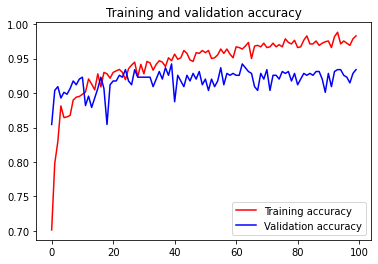

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()